<a href="https://colab.research.google.com/github/burraco135/ICon2023/blob/giac/BeerClassification_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione degli stili di Birra

Per la realizzazione del nostro consigliatore di birre dobbiamo prima effettuare una pulizia e un confronto tra diversi *modelli di apprendimento supervisionato* per la classificazione di stili per ogni tipo di birra. 

L'obiettivo è sicuramente quello di trovare il classificatore che ci restituisca il valore più attendibile per il confronto degli stili in modo da ricercare lo stile più vicino.

In [1]:
# [Issue#1] mount google drive to import csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importiamo i moduli e le librerie di interesse, utili per la realizzazione del sistema.

In [2]:
# import libreries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Analisi Esplorativa & Preparazione dei Dati
Carichiamo il dataset in locale.

In [3]:
# read csv
beer = pd.read_csv('/content/drive/My Drive/CSV/beer_profile_and_ratings.csv')
beer.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


## Pulizia dei dati
###FASE 1:
Eliminamo con il comando drop le colonne che contengono dati che ritieniamo non necessari in modo da alleggerire il dataset per proseguire con l'apprendimento.

In [4]:
# drop columns
beer = beer.drop(columns=['Beer Name (Full)', 'Min IBU', 'Max IBU', 'Description', 'number_of_reviews','review_appearance', 'review_aroma', 'review_palate', 'review_taste'])
beer.head()

,Name,Style,Brewery,ABV,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_overall
0,Amber,Altbier,Alaskan Brewing Co.,5.3,13,32,9,47,74,33,0,33,57,8,111,3.847082
1,Double Bag,Altbier,Long Trail Brewing Co.,7.2,12,57,18,33,55,16,0,24,35,12,84,4.034304
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,5.0,14,37,6,42,43,11,0,10,54,4,62,3.830239
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,8.5,13,55,31,47,101,18,1,49,40,16,119,4.005435
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,7.2,25,51,26,44,45,9,1,11,51,20,95,3.817708


Con questa funzione andiamo a ricercare eventuali valori mancanti, in quanto non possiamo effettuare apprendimento nel caso ci siano dati nulli.

In [5]:
# find null values
print(beer.isnull().sum())

Name              0
Style             0
Brewery           0
ABV               0
Astringency       0
Body              0
Alcohol           0
Bitter            0
Sweet             0
Sour              0
Salty             0
Fruits            0
Hoppy             0
Spices            0
Malty             0
review_overall    0
dtype: int64


Essendo il dataset già ottimizzato per partire già con l'apprendimento otteniamo il seguente risultato:

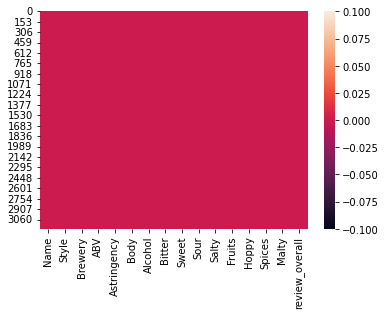

In [6]:
# heatmap for null values
sns.heatmap(beer.isnull())

###FASE 2: normalizzare le feature numeriche e le feature categoriche
Per prima cosa selezioniamo le feature che ci serviranno per classificare i diversi stili di birra.

Nel primo caso  eseguiamo uno scaling basato sul massimo, mentre nel secondo caso lo svolgiamo sul minimo.
Otterremo dei valori identici quindi possiamo ritenerci soddisfatti del risultato.

In [7]:
# normalizzazione features
beer_feature = ['Astringency','Body','Alcohol','Bitter','Sweet','Sour','Salty','Fruits','Hoppy','Spices','Malty']

# maximum absolute scaling
beer_max_scaled = beer.copy()

# apply normalization techniques
for beer_feature in beer_max_scaled[beer_feature]:
    beer_max_scaled[beer_feature] = beer_max_scaled[beer_feature]  / beer_max_scaled[beer_feature].abs().max()

beer_max_scaled.head()

,Name,Style,Brewery,ABV,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_overall
0,Amber,Altbier,Alaskan Brewing Co.,5.3,0.160494,0.182857,0.064748,0.313333,0.281369,0.116197,0.000000,0.188571,0.331395,0.043478,0.464435,3.847082
1,Double Bag,Altbier,Long Trail Brewing Co.,7.2,0.148148,0.325714,0.129496,0.220000,0.209125,0.056338,0.000000,0.137143,0.203488,0.065217,0.351464,4.034304
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,5.0,0.172840,0.211429,0.043165,0.280000,0.163498,0.038732,0.000000,0.057143,0.313953,0.021739,0.259414,3.830239
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,8.5,0.160494,0.314286,0.223022,0.313333,0.384030,0.063380,0.020833,0.280000,0.232558,0.086957,0.497908,4.005435
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,7.2,0.308642,0.291429,0.187050,0.293333,0.171103,0.031690,0.020833,0.062857,0.296512,0.108696,0.397490,3.817708


In [8]:
# normalizzazione features
beer_feature = ['Astringency','Body','Alcohol','Bitter','Sweet','Sour','Salty','Fruits','Hoppy','Spices','Malty']

# minimum absolute scaling
beer_min_max_scaled = beer.copy()

# apply normalization techniques
for beer_feature in beer_min_max_scaled[beer_feature]:
    beer_min_max_scaled[beer_feature] = (beer_min_max_scaled[beer_feature] - beer_min_max_scaled[beer_feature].min()) / (beer_min_max_scaled[beer_feature].max() - beer_min_max_scaled[beer_feature].min())

beer_min_max_scaled.head()

,Name,Style,Brewery,ABV,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_overall
0,Amber,Altbier,Alaskan Brewing Co.,5.3,0.160494,0.182857,0.064748,0.313333,0.281369,0.116197,0.000000,0.188571,0.331395,0.043478,0.464435,3.847082
1,Double Bag,Altbier,Long Trail Brewing Co.,7.2,0.148148,0.325714,0.129496,0.220000,0.209125,0.056338,0.000000,0.137143,0.203488,0.065217,0.351464,4.034304
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,5.0,0.172840,0.211429,0.043165,0.280000,0.163498,0.038732,0.000000,0.057143,0.313953,0.021739,0.259414,3.830239
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,8.5,0.160494,0.314286,0.223022,0.313333,0.384030,0.063380,0.020833,0.280000,0.232558,0.086957,0.497908,4.005435
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,7.2,0.308642,0.291429,0.187050,0.293333,0.171103,0.031690,0.020833,0.062857,0.296512,0.108696,0.397490,3.817708


Attraverso questa heatmap possiamo notare la correlazione tra ogni features che abbiamo preso in considerazione.

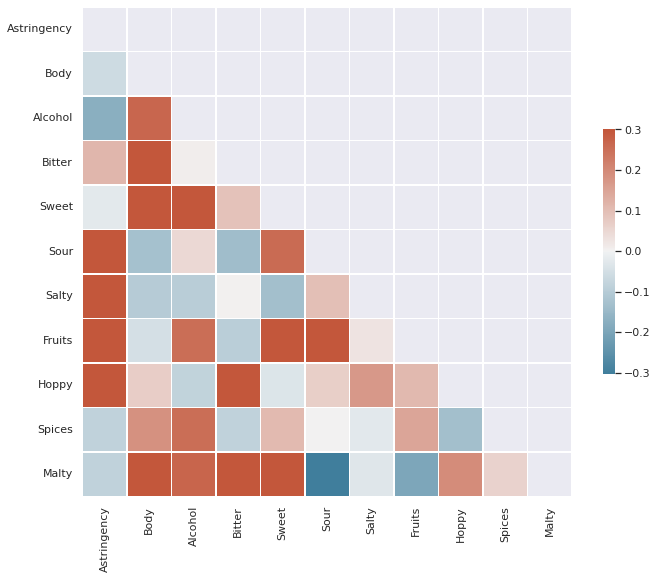

In [9]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="dark")

beer_feature = ['Astringency','Body','Alcohol','Bitter','Sweet','Sour','Salty','Fruits','Hoppy','Spices','Malty']

# Generate a large random dataset
d = beer[beer_feature].copy()

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Siccome ci sono delle feature altamente correlate fra loro dividiamo le features in 3 nuove label che useremo per raggruppare la categoria di uno stile.

In [10]:
# new features
mouthfeel = ['Astringency','Body','Alcohol']
taste = ['Sweet','Bitter','Sour','Salty']
flavour_and_aroma = ['Fruits','Hoppy','Malty','Spices']

<function matplotlib.pyplot.show(*args, **kw)>

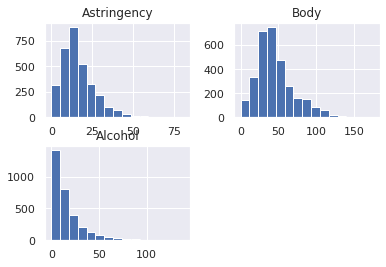

In [11]:
beer[mouthfeel].hist(bins=15)
plt.show

Decidiamo quindi di usare una scala da 1 a 5 per la classificazione dello stile, in quanto in futuro all'interno della kb l'utente dovrà scegliere un target per ogni feature inserendo appunto un valore tra 1 a 5, in modo da soddisfare le sue richieste.

In [12]:
# normalizzazione con valori tra 1 e 5 per le features
from sklearn.preprocessing import MinMaxScaler

beer_feature = ['Astringency','Body','Alcohol','Bitter','Sweet','Sour','Salty','Fruits','Hoppy','Spices','Malty']

df = beer.copy()

scaler = MinMaxScaler(feature_range=(1,5))
df[beer_feature] = scaler.fit_transform(df[beer_feature])

df.head()

,Name,Style,Brewery,ABV,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_overall
0,Amber,Altbier,Alaskan Brewing Co.,5.3,1.641975,1.731429,1.258993,2.253333,2.125475,1.464789,1.000000,1.754286,2.325581,1.173913,2.857741,3.847082
1,Double Bag,Altbier,Long Trail Brewing Co.,7.2,1.592593,2.302857,1.517986,1.880000,1.836502,1.225352,1.000000,1.548571,1.813953,1.260870,2.405858,4.034304
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,5.0,1.691358,1.845714,1.172662,2.120000,1.653992,1.154930,1.000000,1.228571,2.255814,1.086957,2.037657,3.830239
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,8.5,1.641975,2.257143,1.892086,2.253333,2.536122,1.253521,1.083333,2.120000,1.930233,1.347826,2.991632,4.005435
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,7.2,2.234568,2.165714,1.748201,2.173333,1.684411,1.126761,1.083333,1.251429,2.186047,1.434783,2.589958,3.817708


Per semplificare la classificazione per la KB proseguiamo effettuando una regressione e arrotondando i valori delle feature ad una cifra decimale

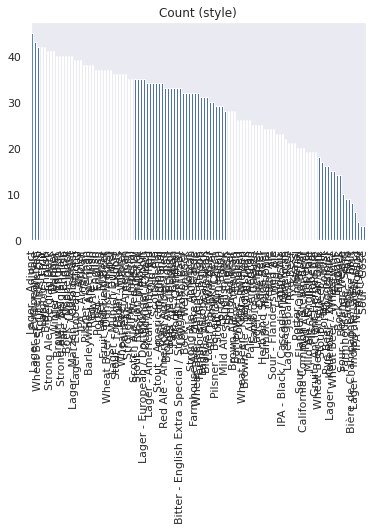

In [13]:
# ci sono troppe recensioni per ogni stile di birra
test = beer

target_count = test['Style'].value_counts()

target_count.plot(kind='bar', title='Count (style)')

Ho raggruppato tutte le birre per beer.Style facendo la media di tutti i valori (essendo dello stesso stile, le feature non possono discostarsi più di tanto tra birre diverse).

Ho rieffettuato lo scaling con il range tra 1 e 5 per avere delle valutazioni normalizzate e ho arrotondato i valori in quanto non mi importa la parte decimale (inoltre crea molti problemi per la classificazione in Prolog).

Quindi ho ottenuto un nuovo dataset che contiene solo gli stili delle birre con le loro feature "medie". Occorre fare un .csv che contiene solo [Codice_stile, Nome_stile], in modo da poter collegare le birre al loro stile.

### Pulizia dei dati
Ci sono troppi dati da elaborare per effettuare una predizione in Prolog (ma anche in Python).
Ho pensato di riassumere le feature di tutti gli stili di birra per ottenere un valore numerico unico.
In questo modo, quando l'utente inserirà i propri "gusti" sarà più semplice confrontarli con quelli di tutti gli stili (essendo solo 111, rispetto al controllo di 3000 righe viene ridotto anche il lavoro).



In [14]:
from sklearn.preprocessing import MinMaxScaler

beer_feature = ['Astringency','Body','Alcohol','Bitter','Sweet','Sour','Salty','Fruits','Hoppy','Spices','Malty']

new = beer.groupby('Style').mean()

scaler = MinMaxScaler(feature_range=(1,5))
new[beer_feature] = scaler.fit_transform(new[beer_feature])

new = new.round(decimals=1)
new = new.drop(columns=['ABV','review_overall'])
new.to_csv('Style_reviews.csv')

new

,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
Style,,,,,,,,,,,
Altbier,2.6,2.4,1.7,2.8,2.9,1.5,1.1,1.9,3.3,1.4,3.9
Barleywine - American,1.9,2.9,4.4,3.4,4.3,1.9,1.1,3.3,3.7,1.6,3.9
Barleywine - English,1.4,2.9,4.7,2.1,5.0,1.7,1.0,3.5,2.0,1.9,4.0
Bitter - English,2.4,2.7,1.5,3.4,2.5,1.7,1.1,2.2,4.2,1.5,3.1
Bitter - English Extra Special / Strong Bitter (ESB),2.3,2.6,1.7,3.6,2.9,1.7,1.0,2.3,4.5,1.4,3.7
...,...,...,...,...,...,...,...,...,...,...,...
Wheat Beer - Kristallweizen,2.1,1.6,1.3,1.3,1.5,1.5,1.1,2.2,1.5,1.6,2.0
Wheat Beer - Wheatwine,1.6,2.4,4.2,1.7,4.0,2.1,1.0,3.5,1.9,1.7,3.4
Wheat Beer - Witbier,2.3,1.9,1.6,1.6,1.9,2.5,1.2,3.7,2.3,2.3,2.0


# Costruzione dei modelli & Addestramento
###Classificazione con modello lineare

La regressione logistica, nonostante il suo nome, è un modello lineare per la classificazione piuttosto che la regressione. In questo modello, le probabilità che descrivono i possibili esiti di una singola prova sono modellate utilizzando una funzione logistica.

In [15]:
from sklearn import linear_model

resh = df.Sweet.head(10).array

regr = linear_model.LinearRegression()
regr.fit(resh.reshape(-1,1), df.Bitter.head(10))

#Calcolo il coefficiente angolare
print(regr.coef_)

[0.21874708]


In [16]:
#Questo è il valore di R^2
regr.score(resh.reshape(-1,1), df.Bitter.head(10))

0.20945225196689055

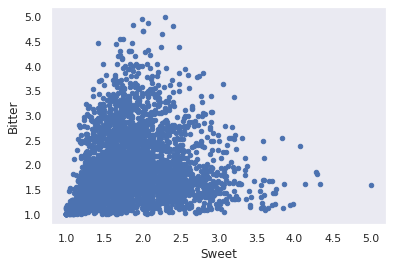

In [17]:
df.plot.scatter(x='Sweet', y='Bitter')

In [18]:
beer_sweet = df[df['Sweet'] <= 1.8]
p_beer_sweet = float(len(beer_sweet)) / len(df)
print(p_beer_sweet)
#abbiamo ricavato la probabilità di un evento stile, ricaviamo la probabilità che una birra sia di grado alcolico 5.3
beer_bitter= df[df['Bitter'] >= 1.8]
p_beer_bitter = float(len(beer_bitter)) / len(df)
print(p_beer_bitter)
#Infine una probabilita P(N|M) si ottiene dividendo il numero di birra che hanno stile altbier con grado alcolico 5.3
beer_sweet_bitter = df[(df['Sweet']<=1.8) & (df['Bitter']>= 1.8)]
p_beer_sweet_bitter = float(len(beer_sweet_bitter)) / len(df)
print(p_beer_sweet_bitter)

0.4832655614638724
0.5201751642164529
0.22521113543947452


In [19]:
#applicando il teorema di bayes possiamo approssimarla come segue
p_beer_sweet_bitter * p_beer_sweet / p_beer_bitter

0.2092310308201973

##Classificatore Naive Bayes
Grazie a questo particolare classificatore  ci permette di calcolare la probabilità che un determinato evento avvenga all'interno del dataset.
Nel nostro caso vogliamo trovare i casi in cui l'Astringency ha una valutazione superiore a 3.

In [20]:
X = df[beer_feature].copy()
df[beer_feature]

,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
0,1.641975,1.731429,1.258993,2.253333,2.125475,1.464789,1.000000,1.754286,2.325581,1.173913,2.857741
1,1.592593,2.302857,1.517986,1.880000,1.836502,1.225352,1.000000,1.548571,1.813953,1.260870,2.405858
2,1.691358,1.845714,1.172662,2.120000,1.653992,1.154930,1.000000,1.228571,2.255814,1.086957,2.037657
3,1.641975,2.257143,1.892086,2.253333,2.536122,1.253521,1.083333,2.120000,1.930233,1.347826,2.991632
4,2.234568,2.165714,1.748201,2.173333,1.684411,1.126761,1.083333,1.251429,2.186047,1.434783,2.589958
...,...,...,...,...,...,...,...,...,...,...,...
3192,1.740741,1.845714,1.690647,1.933333,1.699620,1.267606,1.000000,1.525714,2.046512,2.456522,2.238494
3193,1.740741,1.708571,1.661871,1.426667,1.821293,1.605634,1.000000,2.234286,1.325581,4.043478,1.970711
3194,1.395062,2.005714,1.690647,1.506667,1.790875,1.295775,1.000000,1.594286,1.488372,3.086957,2.288703
3195,1.543210,1.822857,2.438849,2.866667,2.095057,1.830986,1.000000,2.851429,3.558140,1.391304,2.221757


La libreria sklearn mette a disposizione delle classi che permettono di ottenere direttamente un classificatore a partire dai dati iniziali. Per esemplificarne il funzionamento, estraiamo dal nostro dataset alcune colonne relative alle feature.
E' necessario utilizzare solamente dati numerici. Possiamo convertire gli attributi categorici riutilizzando le classi LabelEncoder

In [21]:
from sklearn.preprocessing import LabelEncoder
astringency_encoder = LabelEncoder()
astringency_encoder.fit(X['Astringency'])
X['Astringency'] = astringency_encoder.transform(X['Astringency'])

body_encoder = LabelEncoder()
body_encoder.fit(X['Body'])
X['Body'] = body_encoder.transform(X['Body'])

alcohol_encoder = LabelEncoder()
alcohol_encoder.fit(X['Alcohol'])
X['Alcohol'] = alcohol_encoder.transform(X['Alcohol'])

bitter_encoder = LabelEncoder()
bitter_encoder.fit(X['Bitter'])
X['Bitter'] = bitter_encoder.transform(X['Bitter'])

sweet_encoder = LabelEncoder()
sweet_encoder.fit(X['Sweet'])
X['Sweet'] = sweet_encoder.transform(X['Sweet'])

sour_encoder = LabelEncoder()
sour_encoder.fit(X['Sour'])
X['Sour'] = sour_encoder.transform(X['Sour'])

salty_encoder = LabelEncoder()
salty_encoder.fit(X['Salty'])
X['Salty'] = salty_encoder.transform(X['Salty'])

fruit_encoder = LabelEncoder()
fruit_encoder.fit(X['Fruits'])
X['Fruits'] = fruit_encoder.transform(X['Fruits'])

hoppy_encoder = LabelEncoder()
hoppy_encoder.fit(X['Hoppy'])
X['Hoppy'] = hoppy_encoder.transform(X['Hoppy'])

spices_encoder = LabelEncoder()
spices_encoder.fit(X['Spices'])
X['Spices'] = spices_encoder.transform(X['Spices'])

malty_encoder = LabelEncoder()
malty_encoder.fit(X['Malty'])
X['Malty'] = malty_encoder.transform(X['Malty'])

In [22]:
Y = (df['Style'] == 'Altbier').apply( lambda x: 1 if x else 0)

Utilizziamo in questo caso un modello gaussiano. La costruzione del classificatore viene fatta usando lo stesso procedimento usato per gli alberi di decisione: si crea un oggetto della classe GaussianNB, e poi si invoca su di esso il metodo fit specificando come argomenti le osservazioni e le corrispondenti etichette. Dopo sarà sufficiente invocare il metodo predict passando una lista di oggetti da classificare. Ricordando che per avere una valutazione imparziale di un classificatore è necessario utilizzare dati non utilizzati per costruire il classificatore stesso, per semplicità limitiamoci a verificare che cosa succeda con le osservazioni in X.

In [23]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, Y)
model.predict(X[Y==0])
model.predict(X[Y==1])

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1])

 Per analizzare meglio i risultati, vediamo separatamente come viene classificato dalle due classi.

In [24]:
X[Y==1].index
df.values[X[Y==1].index]

array([['Amber', 'Altbier', 'Alaskan Brewing Co.', 5.3,
        1.6419753086419753, 1.7314285714285713, 1.2589928057553956,
        2.2533333333333334, 2.1254752851711025, 1.4647887323943662, 1.0,
        1.7542857142857144, 2.325581395348837, 1.1739130434782608,
        2.8577405857740583, 3.847082],
       ['Double Bag', 'Altbier', 'Long Trail Brewing Co.', 7.2,
        1.5925925925925926, 2.302857142857143, 1.5179856115107913, 1.88,
        1.8365019011406845, 1.2253521126760563, 1.0, 1.5485714285714285,
        1.8139534883720931, 1.2608695652173914, 2.405857740585774,
        4.034304],
       ['Long Trail Ale', 'Altbier', 'Long Trail Brewing Co.', 5.0,
        1.691358024691358, 1.8457142857142856, 1.1726618705035972, 2.12,
        1.6539923954372624, 1.1549295774647887, 1.0, 1.2285714285714286,
        2.255813953488372, 1.0869565217391304, 2.03765690376569,
        3.830239],
       ['Doppelsticke', 'Altbier',
        'Uerige Obergärige Hausbrauerei GmbH / Zum Uerige', 8.5,
   

A partire dai vettori ottenuti è facile calcolare separatamente il numero di veri positivi, falsi positivi, falsi negativi e veri negativi. È anche possibile costruire un dataframe che contenga la corrispondente matrice di confusione.

In [25]:
tp = sum(model.predict(X[Y==1]))
fn = len(model.predict(X[Y==1])) - tp
fp = sum(model.predict(X[Y==0]))
tn = len(model.predict(X[Y==0])) - fp
pd.DataFrame([[tp, fn],
              [fp, tn]],
              index=['Etichetta positiva', 'Etichetta negativa'],
              columns=['Classif. positiva', 'Classif. negativa'])

,Classif. positiva,Classif. negativa
Etichetta positiva,25,14
Etichetta negativa,264,2894


La matrice evidenzia una poca classificazione delle birre con Astringency > 3 e una performance molto alta per quel che riguarda le altre birre. Volendo riassumere in un unico indice la bontà del risultato ottenuto è possibile calcolare la percentuale di dati corretti. 

In [26]:
#Precision Score = TP / (FP + TP)
precisionGaussian= (tp/ (fp + tp))
#Recall Score = TP / (FN + TP)
recallGaussian = (tp/ (fn + tp))
#Accuracy Score = TP / (FP + TP)
accuracyGaussian = (tp + tn) / float(len(X))
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
f1scoreGaussian = ((2*recallGaussian) / (precisionGaussian + recallGaussian))

print(f'accuracy: {accuracyGaussian}')
print(f'precision: {precisionGaussian}')
print(f'recall: {recallGaussian}')
print(f'f1: {f1scoreGaussian}')

accuracy: 0.9130434782608695
precision: 0.08650519031141868
recall: 0.6410256410256411
f1: 1.7621951219512195


In [27]:
scoring_list = []
scoring_list.append(dict([
    ('Model', 'Gaussian'),
    ('Test Accuracy', round(accuracyGaussian, 3)),
    ('Precision', round(precisionGaussian, 3)),
    ('Recall', round(recallGaussian, 3)),
    ('F1', round(f1scoreGaussian, 3))
     ]))

In [28]:
# Logistic Regression of the beer
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)


logreg = LogisticRegression(max_iter=3196)

# fit the model with data
logreg.fit(X, Y)

# predict the response values for the observations in X
y_test_predict = logreg.predict(X)
tpLog = sum(logreg.predict(X[Y==1]))
fnLog = len(logreg.predict(X[Y==1])) - tpLog
fpLog = sum(logreg.predict(X[Y==0]))
tnLog = len(logreg.predict(X[Y==0])) - fpLog
pd.DataFrame([[tpLog, fn],
              [fpLog, tn]],
              index=['Etichetta positiva', 'Etichetta negativa'],
              columns=['Classif. positiva', 'Classif. negativa'])

,Classif. positiva,Classif. negativa
Etichetta positiva,1,14
Etichetta negativa,0,2894


In [29]:
#Precision Score = TP / (FP + TP)
precisionLogRegression= (tpLog/ (fpLog + tpLog))

#Recall Score = TP / (FN + TP)
recallLogRegression = (tpLog/ (fnLog + tpLog))

#Accuracy Score = TP / (FP + TP)
accuracyLogisticRegression = (tpLog + tnLog) / float(len(X))

#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
f1scoreLogRegression = ((2*recallLogRegression) / (precisionLogRegression + recallLogRegression))

print(f'accuracy: {accuracyLogisticRegression}')
print(f'precision: {precisionLogRegression}')
print(f'recall: {recallLogRegression}')
print(f'f1: {f1scoreLogRegression}')

scoring_list.append(dict([
    ('Model', 'LogisticRegression'),
    ('Test Accuracy', round(accuracyLogisticRegression, 3)),
    ('Precision', round(precisionLogRegression, 3)),
    ('Recall', round(recallLogRegression, 3)),
    ('F1', round(f1scoreLogRegression, 3)),
     ]))

accuracy: 0.9881138567406944
precision: 1.0
recall: 0.02564102564102564
f1: 0.05


In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X, Y)    

# predict the response values for the observations in X
y_test_predict = knn.predict(X)
tpLog = sum(knn.predict(X[Y==1]))
fnLog = len(knn.predict(X[Y==1])) - tpLog
fpLog = sum(knn.predict(X[Y==0]))
tnLog = len(knn.predict(X[Y==0])) - fpLog
pd.DataFrame([[tpLog, fn],
              [fpLog, tn]],
              index=['Etichetta positiva', 'Etichetta negativa'],
              columns=['Classif. positiva', 'Classif. negativa'])

,Classif. positiva,Classif. negativa
Etichetta positiva,1,14
Etichetta negativa,2,2894


In [31]:
#Precision Score = TP / (FP + TP)
precisionKnn= (tpLog/ (fpLog + tpLog))

#Recall Score = TP / (FN + TP)
recallKnn = (tpLog/ (fnLog + tpLog))

#Accuracy Score = TP / (FP + TP)
accuracyKnn = (tpLog + tnLog) / float(len(X))

#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
f1scoreKnn = ((2*recallKnn) / (precisionKnn + recallKnn))

print(f'accuracy: {accuracyKnn}')
print(f'precision: {precisionKnn}')
print(f'recall: {recallKnn}')
print(f'f1: {f1scoreKnn}')

scoring_list.append(dict([
    ('Model', 'KNN'),
    ('Test Accuracy', round(accuracyKnn, 3)),
    ('Precision', round(precisionKnn, 3)),
    ('Recall', round(recallKnn, 3)),
    ('F1', round(f1scoreKnn, 3)),
     ]))

accuracy: 0.9874882702533625
precision: 0.3333333333333333
recall: 0.02564102564102564
f1: 0.14285714285714285


In [32]:
results = pd.DataFrame(data=scoring_list)
results = results[['Model',
                   'Test Accuracy',
                   'Precision',
                   'Recall',
                   'F1']]

results = results.sort_values(by='Recall', ascending=False)

results

,Model,Test Accuracy,Precision,Recall,F1
0,Gaussian,0.913,0.087,0.641,1.762
1,LogisticRegression,0.988,1.000,0.026,0.050
2,KNN,0.987,0.333,0.026,0.143


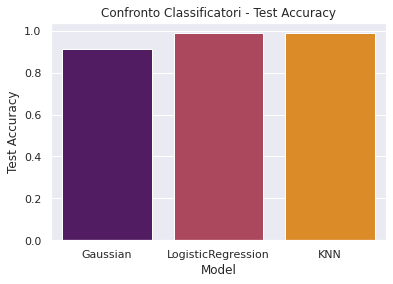

In [33]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Test Accuracy'],
                palette = 'inferno').set(title = "Confronto Classificatori - Test Accuracy")

## Classificatore KNN 
Dopo aver classificato quale sia il più accurato per il nostro dataset, scopriamo che il KNN è il più adeguato per la nostra ricerca di uno stile di birra.
Il principio alla base dei metodi del vicino più vicino è trovare un numero predefinito di campioni di addestramento più vicini alla distanza al nuovo punto e prevedere l'etichetta da questi. Il numero di campioni può essere una costante definita dall'utente (apprendimento del vicino più vicino k) o variare in base alla densità locale dei punti (apprendimento del vicino più vicino basato sul raggio). La distanza può, in generale, essere qualsiasi misura metrica: la distanza euclidea standard è la scelta più comune.
La classificazione basata sui vicini è un tipo di apprendimento basato su istanze o apprendimento non generalizzante: non tenta di costruire un modello interno generale, ma memorizza semplicemente istanze dei dati di addestramento. La classificazione è calcolata da un voto a maggioranza semplice dei vicini più vicini di ciascun punto: a un punto di interrogazione viene assegnata la classe di dati che ha il maggior numero di rappresentanti all'interno dei vicini più vicini del punto. scikit-learn implementa due diversi classificatori dei vicini più vicini: KNeighborsClassifier implementa l'apprendimento basato sui vicini più vicini di ciascun punto di query, dove è un valore intero specificato dall'utente. La classificazione -neighbors in KNeighborsClassifier è la tecnica più comunemente usata. 

In [34]:
from sklearn.neighbors import NearestNeighbors

train_data = df[beer_feature].values

model = NearestNeighbors(n_neighbors=5, algorithm='brute')

model.fit(train_data)


NearestNeighbors(algorithm='brute')

In [35]:
df[beer_feature].shape

(3197, 11)

In [36]:
query_index = np.random.choice(df[beer_feature].shape[0])
print(query_index)
distances, indices = model.kneighbors(df[beer_feature].iloc[query_index,:].values.reshape(1, -1), n_neighbors = 5)

26


Stampa tutta la riga delle 5 nearest neighbours

In [37]:
y_test_predict = df.loc[ df.index[indices.flatten()[0]]]

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(df.loc[df.index[query_index]]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i,df.loc[ df.index[indices.flatten()[i]]], distances.flatten()[i]))

Recommendations for Name                       Lighthouse Amber
Style                               Altbier
Brewery           Cheboygan Brewing Company
ABV                                    5.25
Astringency                         1.54321
Body                               2.531429
Alcohol                            1.143885
Bitter                             1.933333
Sweet                              2.307985
Sour                               1.295775
Salty                                   1.0
Fruits                                 1.64
Hoppy                              2.255814
Spices                             1.086957
Malty                              3.309623
review_overall                          4.0
Name: 26, dtype: object:

1: Name                                   Jenny Lake Lager
Style                                    Lager - Vienna
Brewery           Snake River Brewing Company & Brewpub
ABV                                                 4.8
Astringency            